In [ ]:
import sys
!{sys.executable} -m pip install requests-html

In [ ]:
import sys
!{sys.executable} -m pip install lxml_html_clean

In [9]:
# pip install webdriver-manager
# pip install requests beautifulsoup4 pandas
# pip install selenium
# pip install selenium webdriver-manager
#pip install requests
# pip install requests-html
import requests
from requests_html import HTMLSession
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
# from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time
from urllib.parse import urljoin
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from IPython.display import Markdown, display

from tqdm import tqdm
import time


In [107]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

<div class="span5 alert alert-info">
<h3>BLOCK 1</h3><br>

Scraping cafe names from external websites, to then use the yelp API to search those names 
and accordingly scrape their extensive information

</div>

In [229]:
# Start with meowaround website

API_KEY = 'F-MMiRXPM4HmVbiYChYiwz-qNuVwELkbueD66N4M8x8iFQDiZ8CQGarwJ1trERkHPiNCTKhCZcY1B6aiSw6WWAmE_Hr4AEDB2e4ilZpXlC0lptX4IBRhnz-OF44qaHYx'
HEADERS = {"Authorization": f"Bearer {API_KEY}"}
YELP_URL = "https://api.yelp.com/v3/businesses/search"

base_url = "https://www.meowaround.com"
all_data = []

for page in range(1, 17):
    url = f"{base_url}/continents/north-america?page={page}"
    soup = BeautifulSoup(requests.get(url).text, "html.parser")
    cards = soup.find_all("div", class_="card-row-body")

    for card in cards:
        name_tag = card.find("h2", class_="card-row-title")
        address_tag = card.find_next("div", class_="detail-contact-address")

        if not name_tag or not address_tag:
            continue

        cafe_name = name_tag.get_text(strip=True)
        address = address_tag.get_text(separator=" ", strip=True)

        # Yelp search
        params = {"term": cafe_name, "location": address, "limit": 1}
        response = requests.get(YELP_URL, headers=HEADERS, params=params)
        data = response.json()

        if data.get("businesses"):
            cafe = data["businesses"][0]
            all_data.append({
                "name": cafe.get("name"),
                "city": cafe.get("location", {}).get("city"),
                "rating": cafe.get("rating"),
                "review_count": cafe.get("review_count"),
                "price": cafe.get("price", "N/A"),
                "address": ", ".join(cafe.get("location", {}).get("display_address", [])),
                "latitude": cafe.get("coordinates", {}).get("latitude"),
                "longitude": cafe.get("coordinates", {}).get("longitude"),
                "categories": ", ".join([cat["title"] for cat in cafe.get("categories", [])]),
                "is_closed": cafe.get("is_closed")
            })
        time.sleep(1)  # Respect rate limits

# Convert to DataFrame
df = pd.DataFrame(all_data)
df.to_csv("CafeInfo.csv", index=False)
print("Saved to CafeInfo.csv")

Saved to CafeInfo.csv


In [182]:
## RUN THIS CELL EVERY TIME YOU MAKE MAJOR EDITS SO THAT A NEW CAFEINFO DF IS NOT CREATED AND RUNS AN EMPTY OUTPUT
## this will load any edits you made directly on the sheet, into data that can be manipulated by the commands here
#Check
CafeInfo = pd.read_csv(r"C:\Users\eshab\Downloads\PetCafeSuccess_Capstone2\CafeInfo.csv", encoding='ISO-8859-1') # encoding helps to read the special characters

CafeInfo.head()

,name,city,rating,review_count,price,address,latitude,longitude,categories,is_closed,url,Visit_Type,$$/hour_GenAdmission,successful_or_not
0,Kitty Kisses Cat Cafe,Reno,4.2,64,NaN,"8555 Double R Blvd, Ste 104, Reno, NV 89511",39.460850,-119.764320,Themed Cafes,False,https://kittykissescatcafe.com/book-your-visit/,Appointment,15.00,0
1,Catelowna Cat Cafe,Kelowna,5.0,1,NaN,"1441 Ellis Street, Suite 201, Kelowna, BC V1Y ...",49.887979,-119.493163,Themed Cafes,False,https://catelowna.com/book-a-visit,Appointment,16.00,1
2,Mr. Kitty's Cat Cafe & Boutique,Eau Claire,5.0,2,NaN,"502 S Farwell St, Eau Claire, WI 54701",44.809602,-91.497035,"Themed Cafes, Pet Adoption, Coffee & Tea",False,https://mrkittyscatcafe.as.me/schedule/ddc5358d,Appointment,12.66,1
3,Aristocat Cafe,Harrisonburg,4.9,11,NaN,"111 N Liberty St, Harrisonburg, VA 22802",38.450940,-78.870400,"Coffee & Tea, Cafes, Pet Adoption",False,https://www.aristocat.cafe/reservations,Appointment,15.00,1
4,Rescued Treasures Cat Cafe,Las Vegas,4.6,58,NaN,"4155 N Rancho Dr, Ste 150, Las Vegas, NV 89130",36.235610,-115.230630,"Pet Adoption, Animal Shelters, Themed Cafes",False,https://palnv.org/,Appointment,12.00,1



<div class="span5 alert alert-info">
<h3>BLOCK 1.2</h3><br>

Some urls are incorrect/broken, which is why the visit_type prints as unknown. 
Fix this by making another scraper that accesses urls, more efficiently
at least for the cafes obtained from meowaround.

</div>

In [233]:
# add urls for cafes listed on meowaround website.
if 'url' not in CafeInfo.columns:
    CafeInfo['url'] = None  # or np.nan if you're using numpy

base_url = "https://www.meowaround.com"
updated_urls = {}

# Loop through all 16 MeowAround pages
for page in range(1, 17):
    listing_url = f"{base_url}/continents/north-america?page={page}"
    response = requests.get(listing_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    cards = soup.select("h2.card-row-title a")

    for card in cards:
        name = card.text.strip().lower()
        relative_link = card.get("href")
        full_profile_url = base_url + relative_link

        try:
            profile_resp = requests.get(full_profile_url, timeout=10)
            profile_soup = BeautifulSoup(profile_resp.text, 'html.parser')

            website_tag = profile_soup.select_one("div.detail-contact-website a[href^='http']")
            external_url = website_tag.get("href").strip() if website_tag else full_profile_url

            updated_urls[name] = external_url
        except Exception as e:
            print(f"⚠️ Error fetching {name}: {e}")
            updated_urls[name] = full_profile_url

        time.sleep(0.5)

# Normalize CafeInfo name for matching
CafeInfo['name_lower'] = CafeInfo['name'].str.strip().str.lower()

# Update 'url' based on name match
CafeInfo['url'] = CafeInfo.apply(
    lambda row: updated_urls.get(row['name_lower'], row['url']),
    axis=1
)

# Drop helper column
CafeInfo.drop(columns=['name_lower'], inplace=True)

#Save progress
CafeInfo.to_csv("CafeInfo.csv", index=False)

# Preview result
print(CafeInfo[['name', 'url']].tail(10))

                                      name  \
121                           PHX Cat Cafe   
122                       Orlando Cat Cafe   
123                    Nine Lives Cat Cafe   
124                           Meow Parlour   
125                        Bastet Cat Café   
126                                  Catfe   
127  Crumbs & Whiskers - Kitten & Cat Cafe   
128                        Pounce Cat Cafe   
129                               Cat Town   
130                    Treetops Kitty Cafe   

                                                   url  
121                                               None  
122          http://orlandocatcafe.com/?ref=meowaround  
123       http://www.ninelivesindy.com/?ref=meowaround  
124         http://www.meowparlour.com/?ref=meowaround  
125  https://www.facebook.com/bastetcatcafe/?ref=me...  
126                                               None  
127                                               None  
128                                  

<div class="span5 alert alert-info">
<h3>BLOCK 1.3</h3><br>
Keep scraping external websites and running them through yelp queries
This time keep the yelp biz urls out of the quey so that erros do not come up when trying to scrape further information on the 
businesses that can only come from their homepage. Information such as gen admission prices or the cafe's visit type'. 
</div>


In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
# Set up headless Chrome
options = Options()
options.headless = True
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# Go to the page
base_url = "https://www.cattipper.com/the-cat-cafe-directory"
driver.get(base_url)

# Get full rendered HTML
soup = BeautifulSoup(driver.page_source, "html.parser")

# Extract cafe data
cafe_names = []
cafe_homepages = []

for li in soup.select("ul.wp-block-list li"):
    a_tag = li.find("a")
    if a_tag and a_tag.text.strip():
        cafe_names.append(a_tag.text.strip())
        cafe_homepages.append(a_tag.get("href", "").strip())

driver.quit()

print(f"Scraped {len(cafe_names)} cafes from CatTipper")


In [328]:
#store the homepages
homepage_df = pd.DataFrame({
    "name": cafe_names,
    "url": cafe_homepages
})

# Merge this homepage info into your main CafeInfo DataFrame
CafeInfo = CafeInfo.merge(homepage_df, on="name", how="left")

# Optional: Check results
print(CafeInfo.head())

                              name          city  rating  review_count price  \
0            Kitty Kisses Cat Cafe          Reno     4.2            64   NaN   
1        Planet Perk - City Center       Oshkosh     4.2            45    $$   
2               Catelowna Cat Cafe       Kelowna     5.0             1   NaN   
3  Mr. Kitty's Cat Cafe & Boutique    Eau Claire     5.0             2   NaN   
4                   Aristocat Cafe  Harrisonburg     4.9            11   NaN   

                                             address   latitude   longitude  \
0        8555 Double R Blvd, Ste 104, Reno, NV 89511  39.460850 -119.764320   
1                   100C City Ctr, Oshkosh, WI 54901  44.016327  -88.539725   
2  1441 Ellis Street, Suite 201, Kelowna, BC V1Y ...  49.887979 -119.493163   
3             502 S Farwell St, Eau Claire, WI 54701  44.809602  -91.497035   
4           111 N Liberty St, Harrisonburg, VA 22802  38.450940  -78.870400   

                                 categories 

In [ ]:
API_KEY = 'F-MMiRXPM4HmVbiYChYiwz-qNuVwELkbueD66N4M8x8iFQDiZ8CQGarwJ1trERkHPiNCTKhCZcY1B6aiSw6WWAmE_Hr4AEDB2e4ilZpXlC0lptX4IBRhnz-OF44qaHYx' 
headers = {"Authorization": f"Bearer {API_KEY}"}
search_url = "https://api.yelp.com/v3/businesses/search"

all_data = []

for name in cafe_names:
    params = {
        "term": name,
        "location": "United States",  # You can make this more precise if needed
        "limit": 1
    }
    response = requests.get(YELP_URL, headers=HEADERS, params=params)
    data = response.json()

    if data.get("businesses"):
        cafe = data["businesses"][0]
        all_data.append({
            "name": name,
            "Yelp_Name": cafe.get("name"),
            "City": cafe.get("location", {}).get("city"),
            "Rating": cafe.get("rating"),
            "Review_Count": cafe.get("review_count"),
            "Price": cafe.get("price", "N/A"),
            "Address": ", ".join(cafe.get("location", {}).get("display_address", [])),
            "Latitude": cafe.get("coordinates", {}).get("latitude"),
            "Longitude": cafe.get("coordinates", {}).get("longitude"),
            "Categories": ", ".join([cat["title"] for cat in cafe.get("categories", [])]),
            "Is_Closed": cafe.get("is_closed")
        })
    else:
        all_data.append({            #because I didnt use the same column names as what was in my CafeInfo df, new columns were creeated 
            "Cafe_Name": name,
            "Yelp_Name": None,
            "City": None,
            "Rating": None,
            "Review_Count": None,
            "Price": None,
            "Address": None,
            "Latitude": None,
            "Longitude": None,
            "Categories": None,
            "Is_Closed": None
        })

    time.sleep(1)  # Respect Yelp's rate limit

# Merge the scraped data into your existing CafeInfo DataFrame
yelp_df = pd.DataFrame(all_data)

# Merge on name (assuming both DataFrames have this column)
CafeInfo = CafeInfo.merge(yelp_df, on="name", how="left")

In [326]:
CafeInfo.head()

,name,city,rating,review_count,price,address,latitude,longitude,categories,is_closed,...,Yelp_Name,City,Rating,Review_Count,Price,Address,Latitude,Longitude,Categories,Is_Closed
0,Kitty Kisses Cat Cafe,Reno,4.2,64,NaN,"8555 Double R Blvd, Ste 104, Reno, NV 89511",39.460850,-119.764320,Themed Cafes,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Planet Perk - City Center,Oshkosh,4.2,45,$$,"100C City Ctr, Oshkosh, WI 54901",44.016327,-88.539725,"Cafes, Breakfast & Brunch",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Catelowna Cat Cafe,Kelowna,5.0,1,NaN,"1441 Ellis Street, Suite 201, Kelowna, BC V1Y ...",49.887979,-119.493163,Themed Cafes,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Mr. Kitty's Cat Cafe & Boutique,Eau Claire,5.0,2,NaN,"502 S Farwell St, Eau Claire, WI 54701",44.809602,-91.497035,"Themed Cafes, Pet Adoption, Coffee & Tea",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aristocat Cafe,Harrisonburg,4.9,11,NaN,"111 N Liberty St, Harrisonburg, VA 22802",38.450940,-78.870400,"Coffee & Tea, Cafes, Pet Adoption",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="span5 alert alert-info">
<h3>BLOCK 2</h3><br>
Now clean up extra little details like redundance and keep an eye out for NaN values
</div>

In [ ]:
CafeInfo = CafeInfo.drop(['Yelp_Name', 'City', 'Review_Count', 'Price', 'Address', 'Latitude', 'Longitude', 'Categories', 'Is_Closed'], axis=1)

In [330]:
#delete repetitive cafes
CafeInfo = CafeInfo.drop_duplicates(subset=["name", "address"], keep="first").reset_index(drop=True)

# save cleaned data
CafeInfo.to_csv("CafeInfo.csv", index=False)

In [354]:
# Overwrite url_x with url_y where url_y is not null
CafeInfo.loc[CafeInfo['url_y'].notna(), 'url_x'] = CafeInfo['url_y']

# Drop url_y afterward
CafeInfo.drop(columns=['url_y'], inplace=True)

print("url_y values transferred to url_x and url_y column removed.")

url_y values transferred to url_x (row-wise, no shifting) and url_y column removed.


In [356]:
CafeInfo.rename(columns={'url_x': 'url'}, inplace=True)
CafeInfo.head()

,name,city,rating,review_count,price,address,latitude,longitude,categories,is_closed,url,Visit_Type,Rating
0,Kitty Kisses Cat Cafe,Reno,4.2,64,NaN,"8555 Double R Blvd, Ste 104, Reno, NV 89511",39.460850,-119.764320,Themed Cafes,False,http://www.kittykissescatcafe.com?ref=meowaround,Appointment,NaN
1,Planet Perk - City Center,Oshkosh,4.2,45,$$,"100C City Ctr, Oshkosh, WI 54901",44.016327,-88.539725,"Cafes, Breakfast & Brunch",False,NaN,Error,NaN
2,Catelowna Cat Cafe,Kelowna,5.0,1,NaN,"1441 Ellis Street, Suite 201, Kelowna, BC V1Y ...",49.887979,-119.493163,Themed Cafes,False,NaN,Error,NaN
3,Mr. Kitty's Cat Cafe & Boutique,Eau Claire,5.0,2,NaN,"502 S Farwell St, Eau Claire, WI 54701",44.809602,-91.497035,"Themed Cafes, Pet Adoption, Coffee & Tea",False,https://mrkittyscatcafe.com/?ref=meowaround,Appointment,NaN
4,Aristocat Cafe,Harrisonburg,4.9,11,NaN,"111 N Liberty St, Harrisonburg, VA 22802",38.450940,-78.870400,"Coffee & Tea, Cafes, Pet Adoption",False,https://www.aristocat.cafe/?ref=meowaround,Unknown,NaN


In [212]:
#Save progress
CafeInfo.to_csv("CafeInfo.csv", index=False)

In [364]:
# Overwrite 'ratings' with 'Ratings' where 'Ratings' is not null
CafeInfo.loc[CafeInfo['Rating'].notna(), 'rating'] = CafeInfo['Rating']

# Drop 
CafeInfo.drop(columns=['Rating'], inplace=True)

print("'Ratings' values copied to 'ratings' where available, and 'Ratings' column removed.")

CafeInfo.head()

'Ratings' values copied to 'ratings' where available, and 'Ratings' column removed.


,name,city,rating,review_count,price,address,latitude,longitude,categories,is_closed,url,Visit_Type
0,Kitty Kisses Cat Cafe,Reno,4.2,64,NaN,"8555 Double R Blvd, Ste 104, Reno, NV 89511",39.460850,-119.764320,Themed Cafes,False,http://www.kittykissescatcafe.com?ref=meowaround,Appointment
1,Planet Perk - City Center,Oshkosh,4.2,45,$$,"100C City Ctr, Oshkosh, WI 54901",44.016327,-88.539725,"Cafes, Breakfast & Brunch",False,NaN,Error
2,Catelowna Cat Cafe,Kelowna,5.0,1,NaN,"1441 Ellis Street, Suite 201, Kelowna, BC V1Y ...",49.887979,-119.493163,Themed Cafes,False,NaN,Error
3,Mr. Kitty's Cat Cafe & Boutique,Eau Claire,5.0,2,NaN,"502 S Farwell St, Eau Claire, WI 54701",44.809602,-91.497035,"Themed Cafes, Pet Adoption, Coffee & Tea",False,https://mrkittyscatcafe.com/?ref=meowaround,Appointment
4,Aristocat Cafe,Harrisonburg,4.9,11,NaN,"111 N Liberty St, Harrisonburg, VA 22802",38.450940,-78.870400,"Coffee & Tea, Cafes, Pet Adoption",False,https://www.aristocat.cafe/?ref=meowaround,Unknown


In [366]:
#Save progress again for it to show up in the spreadsheet!
CafeInfo.to_csv("CafeInfo.csv", index=False)

<div class="span5 alert alert-info">
<h3>BLOCK 3</h3><br>
Extract visit types information from urls. But this can only be done if the urls are accurate/not-broken
</div>

In [ ]:
# Define keyword sets
appointment_keywords = [
    "reservation", "book", "appointment", "schedule", "reserve", "booking", "pre-book", "time slot"
]

walkin_keywords = [
    "walk in", "walk-ins welcome", "no reservation", "drop in",
    "first come", "no appointment", "walk-in only"
]

visit_types = []

if 'url' in CafeInfo.columns:
    for i, url in tqdm(enumerate(CafeInfo['url']), total=len(CafeInfo)):
        visit_type = "Unknown"

        if not isinstance(url, str) or not url.startswith("http"):
            visit_types.append("Error")
            continue

        try:
            pages_to_check = [url]

            # Step 1: Get homepage and search for booking text and links
            response = requests.get(url, timeout=10)
            soup = BeautifulSoup(response.text, 'html.parser')
            text = soup.get_text().lower()

            # First pass: keyword check on homepage
            if any(word in text for word in appointment_keywords):
                visit_type = "Appointment"
            elif any(word in text for word in walkin_keywords):
                visit_type = "Walk-in"
            else:
                # Step 2: Try subpages with keywords in the URL
                links = soup.find_all('a', href=True)
                for link in links:
                    href = link['href'].lower()
                    if any(kw in href for kw in ['visit', 'book', 'reserve', 'schedule']):
                        full_url = urljoin(url, href)
                        if full_url not in pages_to_check:
                            pages_to_check.append(full_url)

                # Check those subpages
                for page_url in pages_to_check[1:]:
                    try:
                        sub_res = requests.get(page_url, timeout=10)
                        sub_soup = BeautifulSoup(sub_res.text, 'html.parser')
                        sub_text = sub_soup.get_text().lower()

                        if any(word in sub_text for word in appointment_keywords):
                            visit_type = "Appointment"
                            break
                        elif any(word in sub_text for word in walkin_keywords):
                            visit_type = "Walk-in"
                            break
                    except Exception as e:
                        print(f"⚠️ Subpage failed ({page_url}): {e}")
                        continue

        except Exception as e:
            print(f"⚠️ Main page failed ({url}): {e}")
            visit_type = "Error"

        visit_types.append(visit_type)
        time.sleep(1.0)  # rate limiting

    CafeInfo['Visit_Type'] = visit_types
    CafeInfo.to_csv("CafeInfo.csv", index=False)

else:
    print(" 'url' column not found in CafeInfo.")


<div class="span5 alert alert-info">
<h3>BLOCK 4</h3><br>
after executing that scraper, it became clear most, if not all, cat cafes relied most on appointment-based business rather than walk-ins. 
So using that as a determinant for cat cafe success would be redundant. Instead, I am going to now focus on
extracting/scraping gen admission prices for reserving a 1 hour session.
</div>

In [7]:
# Add column that specifies general admission prices
CafeInfo['$$/hour_GenAdmission'] = np.nan

In [29]:
CafeInfo.head()

,name,city,rating,review_count,price,address,latitude,longitude,categories,is_closed,url,Visit_Type,$$/hour_GenAdmission
0,Kitty Kisses Cat Cafe,Reno,4.2,64,NaN,"8555 Double R Blvd, Ste 104, Reno, NV 89511",39.460850,-119.764320,Themed Cafes,False,https://kittykissescatcafe.com/book-your-visit/,Appointment,NaN
1,Catelowna Cat Cafe,Kelowna,5.0,1,NaN,"1441 Ellis Street, Suite 201, Kelowna, BC V1Y ...",49.887979,-119.493163,Themed Cafes,False,https://catelowna.com/book-a-visit,Appointment,NaN
2,Mr. Kitty's Cat Cafe & Boutique,Eau Claire,5.0,2,NaN,"502 S Farwell St, Eau Claire, WI 54701",44.809602,-91.497035,"Themed Cafes, Pet Adoption, Coffee & Tea",False,https://mrkittyscatcafe.as.me/schedule/ddc5358d,Appointment,NaN
3,Aristocat Cafe,Harrisonburg,4.9,11,NaN,"111 N Liberty St, Harrisonburg, VA 22802",38.450940,-78.870400,"Coffee & Tea, Cafes, Pet Adoption",False,https://www.aristocat.cafe/reservations,Appointment,NaN
4,Rescued Treasures Cat Cafe,Las Vegas,4.6,58,NaN,"4155 N Rancho Dr, Ste 150, Las Vegas, NV 89130",36.235610,-115.230630,"Pet Adoption, Animal Shelters, Themed Cafes",False,https://palnv.org/,Appointment,12.0


In [25]:
CafeInfo.to_csv("CafeInfo.csv", index=False) #save point after checking everything was good enough to change the og df sheet

In [ ]:
from tqdm import tqdm
price_patterns = [
    r"\$ ?(\d{1,3}(?:\.\d{1,2})?) ?(per\s?hour|/hour|/hr|hr)",                   # $15/hour
    r"(?:admission|entry fee|price)[: ]*\$ ?(\d{1,3}(?:\.\d{1,2})?)",            # Admission: $15
    r"\$ ?(\d{1,3}(?:\.\d{1,2})?) ?(entry|admission|per person|for 1 hour)",     # $10 admission
    r"\$ ?(\d{1,3}(?:\.\d{1,2})?).*?(1\s?(hour|hr))"                             # $12 for 1 hour
]

# Clean up any old data in the column
CafeInfo['$$/hour_GenAdmission'] = None

for i, row in tqdm(CafeInfo.iterrows(), total=len(CafeInfo)):
    url = row.get("url")
    if not isinstance(url, str) or not url.startswith("http"):
        continue

    price_found = None

    try:
        pages_to_check = [url]  # Start with the homepage

        # Get homepage and look for potential subpages
        response = requests.get(url, timeout=10)
        soup = BeautifulSoup(response.text, 'html.parser')

        text = soup.get_text(separator=' ', strip=True)
        links = soup.find_all("a", href=True)

        # Add "visit", "book", or "reserve" subpages
        for link in links:
            href = link['href'].lower()
            if any(word in href for word in ['visit', 'book', 'reserve']):
                full_link = urljoin(url, href)
                if full_link not in pages_to_check:
                    pages_to_check.append(full_link)

        # Scrape all selected pages for pricing patterns
        for page_url in pages_to_check:
            try:
                res = requests.get(page_url, timeout=10)
                page_soup = BeautifulSoup(res.text, 'html.parser')
                page_text = page_soup.get_text(separator=' ', strip=True).lower()

                for pattern in price_patterns:
                    matches = re.findall(pattern, page_text, re.IGNORECASE)
                    if matches:
                        for match in matches:
                            try:
                                if isinstance(match, tuple):
                                    price = float(match[0])
                                else:
                                    price = float(match)
                                price_found = price
                                break
                            except:
                                continue
                    if price_found:
                        break
            except:
                continue

        if price_found is not None:
            CafeInfo.at[i, '$$/hour_GenAdmission'] = price_found

    except Exception as e:
        print(f"Error on {url}: {e}")

CafeInfo.to_csv("CafeInfo.csv", index=False)

In [24]:
CafeInfo.head()

,name,city,rating,review_count,price,address,latitude,longitude,categories,is_closed,url,Visit_Type,$$/hour_GenAdmission
0,Kitty Kisses Cat Cafe,Reno,4.2,64.0,NaN,"8555 Double R Blvd, Ste 104, Reno, NV 89511",39.460850,-119.764320,Themed Cafes,False,https://kittykissescatcafe.com/book-your-visit/,Appointment,15.00
1,Catelowna Cat Cafe,Kelowna,5.0,1.0,NaN,"1441 Ellis Street, Suite 201, Kelowna, BC V1Y ...",49.887979,-119.493163,Themed Cafes,False,https://catelowna.com/book-a-visit,Appointment,16.00
2,Mr. Kitty's Cat Cafe & Boutique,Eau Claire,5.0,2.0,NaN,"502 S Farwell St, Eau Claire, WI 54701",44.809602,-91.497035,"Themed Cafes, Pet Adoption, Coffee & Tea",False,https://mrkittyscatcafe.as.me/schedule/ddc5358d,Appointment,12.66
3,Aristocat Cafe,Harrisonburg,4.9,11.0,NaN,"111 N Liberty St, Harrisonburg, VA 22802",38.450940,-78.870400,"Coffee & Tea, Cafes, Pet Adoption",False,https://www.aristocat.cafe/reservations,Appointment,15.00
4,Rescued Treasures Cat Cafe,Las Vegas,4.6,58.0,NaN,"4155 N Rancho Dr, Ste 150, Las Vegas, NV 89130",36.235610,-115.230630,"Pet Adoption, Animal Shelters, Themed Cafes",False,https://palnv.org/,Appointment,12.00


In [19]:
CafeInfo.to_csv("CafeInfo.csv", index=False)

<div class="span5 alert alert-info">
<h3>BLOCK 5</h3><br>
now create a categorical variable column called, successful_or_not, that has 0 represent not succcessful
(ratings under 4.2) and 1- as successful for cafes rated higher than 4.2 in the 'rating' column.
</div>

In [26]:
CafeInfo['successful_or_not'] = CafeInfo['rating'].apply(lambda x: 1 if pd.notnull(x) and x > 4.2 else 0)

# Preview the result
CafeInfo[['rating', 'successful_or_not']].head()

,rating,successful_or_not
0,4.2,0
1,5.0,1
2,5.0,1
3,4.9,1
4,4.6,1


In [28]:
CafeInfo.to_csv("CafeInfo.csv", index=False)
CafeInfo.head()

,name,city,rating,review_count,price,address,latitude,longitude,categories,is_closed,url,Visit_Type,$$/hour_GenAdmission,successful_or_not
0,Kitty Kisses Cat Cafe,Reno,4.2,64.0,NaN,"8555 Double R Blvd, Ste 104, Reno, NV 89511",39.460850,-119.764320,Themed Cafes,False,https://kittykissescatcafe.com/book-your-visit/,Appointment,15.00,0
1,Catelowna Cat Cafe,Kelowna,5.0,1.0,NaN,"1441 Ellis Street, Suite 201, Kelowna, BC V1Y ...",49.887979,-119.493163,Themed Cafes,False,https://catelowna.com/book-a-visit,Appointment,16.00,1
2,Mr. Kitty's Cat Cafe & Boutique,Eau Claire,5.0,2.0,NaN,"502 S Farwell St, Eau Claire, WI 54701",44.809602,-91.497035,"Themed Cafes, Pet Adoption, Coffee & Tea",False,https://mrkittyscatcafe.as.me/schedule/ddc5358d,Appointment,12.66,1
3,Aristocat Cafe,Harrisonburg,4.9,11.0,NaN,"111 N Liberty St, Harrisonburg, VA 22802",38.450940,-78.870400,"Coffee & Tea, Cafes, Pet Adoption",False,https://www.aristocat.cafe/reservations,Appointment,15.00,1
4,Rescued Treasures Cat Cafe,Las Vegas,4.6,58.0,NaN,"4155 N Rancho Dr, Ste 150, Las Vegas, NV 89130",36.235610,-115.230630,"Pet Adoption, Animal Shelters, Themed Cafes",False,https://palnv.org/,Appointment,12.00,1


<div class="span5 alert alert-info">
<h3>BLOCK 5.2</h3><br>
Now train and test data in the columns with necessary data that will be used to evaluate success.
</div>

In [184]:
# Numeric columns to scale
numeric_cols = ['rating', '$$/hour_GenAdmission', 'successful_or_not']  
scaler = StandardScaler()

# Fit and transform
scaled_numeric = scaler.fit_transform(CafeInfo[numeric_cols])
scaled_numeric_df = pd.DataFrame(scaled_numeric, columns=[f"scaled_{col}" for col in numeric_cols])

# Drop original numeric columns and replace with scaled
CafeInfo_scaled = CafeInfo.drop(columns=numeric_cols).reset_index(drop=True)
CafeInfo_scaled = pd.concat([CafeInfo_scaled, scaled_numeric_df], axis=1)

In [186]:
# Only predictor and target from scaled data
X = CafeInfo_scaled[['scaled_successful_or_not']]
y = CafeInfo_scaled['scaled_$$/hour_GenAdmission']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Coefficients
coef = model.coef_[0]
intercept = model.intercept_

print(f"Intercept (baseline price, scaled): {intercept:.2f}")
print(f"Effect of being successful (scaled): {coef:.2f}")

Intercept (baseline price, scaled): 0.09
Effect of being successful (scaled): 0.14


In [188]:

# Predict price using success as predictor
X = CafeInfo[['successful_or_not']]
y = CafeInfo['$$/hour_GenAdmission']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Coefficients
intercept = model.intercept_
coef = model.coef_[0]

unsuccessful_price = intercept
successful_price = intercept + coef

print(f"Base price (unsuccessful cafes): ${unsuccessful_price:.2f}")
print(f"Base price (successful cafes): ${successful_price:.2f}")
print(f"Price difference (success effect): ${coef:.2f}")

Base price (unsuccessful cafes): $14.74
Base price (successful cafes): $16.86
Price difference (success effect): $2.12


<div class="span5 alert alert-info">
<h3>BLOCK 6</h3><br>
Now it is best to create two to three different models and identify the best one...
</div>

In [190]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

#Random Forest 
rf = RandomForestRegressor(random_state=42)
param_grid = {'n_estimators': [50, 100], 'max_depth': [2, 4, 6]}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
rf_best = grid_search.best_estimator_
rf_pred = rf_best.predict(X_test)


In [191]:
def evaluate_model(y_test, pred, name):
    r2 = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f"{name} -- R²: {r2:.3f}, RMSE: {rmse:.3f}")

evaluate_model(y_test, lr_pred, "Linear Regression")
evaluate_model(y_test, dt_pred, "Decision Tree")
evaluate_model(y_test, rf_pred, "Random Forest")


Linear Regression -- R²: -0.517, RMSE: 6.813
Decision Tree -- R²: -0.517, RMSE: 6.813
Random Forest -- R²: -0.529, RMSE: 6.839


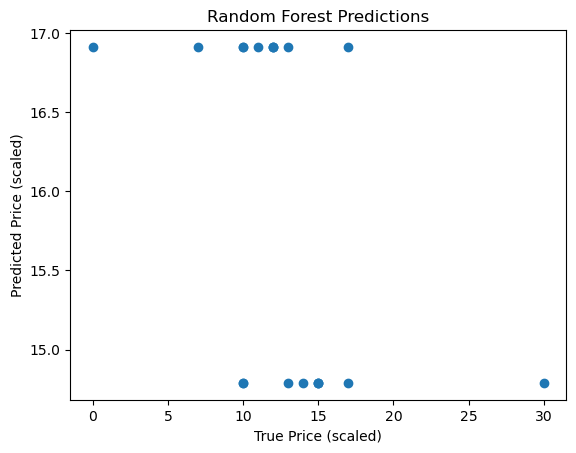

In [194]:
plt.scatter(y_test, rf_pred)
plt.xlabel("True Price (scaled)")
plt.ylabel("Predicted Price (scaled)")
plt.title("Random Forest Predictions")
plt.show()


<div class="span5 alert alert-info">
<h3>BLOCK 7</h3><br>
Since the models did not perform that well, I want to reframe my insight to be a little more complex by
classifying and evaluating various price tiers.
</div>

In [200]:
# Bin the scaled prices into tiers
bins = [0, 10, 18, float('inf')]
labels = ['Low', 'Medium', 'High']
CafeInfo['price_tier'] = pd.cut(CafeInfo['$$/hour_GenAdmission'], bins=bins, labels=labels, include_lowest=True)


print(CafeInfo['$$/hour_GenAdmission'].isna().sum())
nan_rows = CafeInfo[ CafeInfo['price_tier'].isna() ]
print(nan_rows[['$$/hour_GenAdmission', 'price_tier']])

# Handle any potential NaNs before encoding
#CafeInfo_scaled['price_tier'] = CafeInfo_scaled['price_tier'].astype(str)


0
Empty DataFrame
Columns: [$$/hour_GenAdmission, price_tier]
Index: []


In [204]:
# Encode the tiers
le = LabelEncoder()
CafeInfo['price_tier_encoded'] = le.fit_transform(CafeInfo['price_tier'])

In [206]:
# Define features and target
X = CafeInfo[['rating']]
y = CafeInfo['price_tier_encoded']

# Step 5: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [208]:
# Fit model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [210]:
# Make predictions
y_pred = clf.predict(X_test)

# Convert class labels to strings (safe for report)
target_names = [str(cls) for cls in le.classes_]

#Evaluation
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.00      0.00      0.00         1
         Low       0.00      0.00      0.00         6
      Medium       0.50      0.58      0.54        12

    accuracy                           0.37        19
   macro avg       0.17      0.19      0.18        19
weighted avg       0.32      0.37      0.34        19

[[0 0 1]
 [0 0 6]
 [3 2 7]]
